# 🐍 Python for Hydrology
<br>
<img style="float: left; padding-right: 15px; padding-left: 0px;" src="../sources/images/logo_continuum.png" width="260px" align=”left” >

<div style="text-align: justify">This is a Jupyter Notebook, a web-based interactive development environment that allows to create and share python codes. 
    
First things first, what is **Python**? Python is an high-level and general-purpose programming language. It can be used to write software in a wide variety of application domains, including hydrology. Python can be used to perform numerical calculations, statistical analyses or to access and plot data (even large datasets).

    
In Jupyter Notebook the *Python shell* is embedded. The shell is where you can write and execute a line (or multiple lines) of code. Python is open-source, and several packages are available covering many scientific and technological fields.



## 👣 First steps

Let's start using Python as a calculator:

In [1]:
# Set the name of the settings file
190/3

63.333333333333336

If needed we can assign this result to a variable, and use the variable for further math or for other operations (such as converting to integer and priting it).

In [2]:
result = 190/3
new_result = result - 14
int_result = int(new_result)
print(int(int_result))

49


What if we want to perform some more complex calculus? 

Python has several **libraries** suitable for different task. Each library require the **import** .
We can for example import the math package, loading several mathematical functions (such as the square root)



In [3]:
import math

sqrt_result = math.sqrt(int_result)
print(sqrt_result)

7.0


What if we want to work not with a single value, but with a **vector** composed of multiple values?

In [4]:
import numpy as np

array = np.random.rand(5)
print(array)

[0.34884801 0.53152922 0.56801304 0.2116662  0.74897815]


Slicing vectors start from 0...

In [5]:
first_value = array[0]

We can do operation on vectors

In [6]:
array = [1,4,100,3,-2]
print(array)
print('------> complete array maximum: ' + str(np.max(array)))

array_nan = array
array_nan[2] = np.nan
print(array_nan)
print('------> incomplete array maximum: ' + str(np.max(array)))

[1, 4, 100, 3, -2]
------> complete array maximum: 100
[1, 4, nan, 3, -2]
------> incomplete array maximum: nan


Is the last result correct? Shouldn't be 4 the new maximum value? We can use a specific function for accounting for "nan" or missing values: np.nanmax (part of numpy package)

In [7]:
print('------> incomplete array maximum: ' + str(np.nanmax(array)))

------> incomplete array maximum: 4.0


---

## 📈 Dealing with timeseries

Can we generate timeseries (multiple values with associated date) and plot it? Of course! Let's start by importing some useful libraries!

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from urllib.request import urlopen, Request
import os

# We can also define personal function, this one for example allow to visualize the output of dropdowns menus
def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            print("Selected value: " + change['new'])

We can now proceed with a random timeseries!

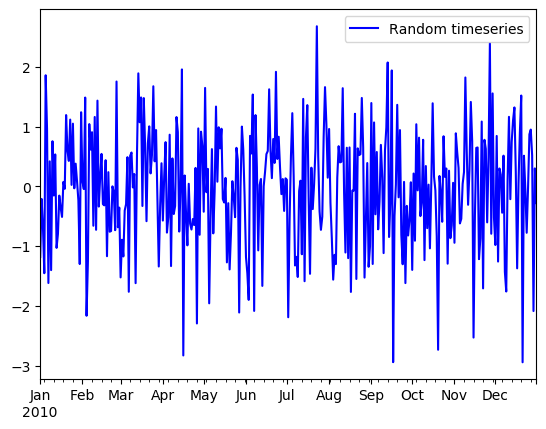

In [9]:
ts = pd.Series(np.random.randn(365), index=pd.date_range('1/1/2010', periods=365))
plt.figure()
ts.plot(style='b-', label='Random timeseries')
plt.legend()

Most interesting is to work with existing timeseries. The NOAA provides a global dataset of daily rainfall and temperature values, the **Global Historical Climate Network Daily** (https://www.ncdc.noaa.gov/ghcn-daily-description).
The dataset can be queried by country by selecting it from the following dropdown menu.

In [10]:
# Load list of available countries and generate dropdown selector
with open('../sources/datasets/ghcnd/ghcnd-countries.txt', 'r') as file:
    list_country = [line for line in file]
country_chooser = widgets.Dropdown(
    options=['Choose a country'] + list_country,
    value='Choose a country',
    description='Country:',
    disabled=False,
)
country_chooser.observe(on_change)
display(country_chooser)

Dropdown(description='Country:', options=('Choose a country', 'AC Antigua and Barbuda \n', 'AE United Arab Emi…

Selected value: ET Ethiopia 



By executing the next piece of code a dropdown menu of the available station for the selected country will be show. Please, select the station of interest. 
**NB!** Some countries (Brazil, Australia and US) have too many station and can break the system, for those countries manual selection of the station is feasible!



In [12]:
# Generate the list of the available stations
country_code = country_chooser.value[0:2]
list_stations = pd.read_fwf('../sources/datasets/ghcnd/ghcnd-stations.txt',
                            widths=[2,9,9,10,7,4,31,3,10],
                            header=None, usecols=[0,1,2,3,4,6], 
                            names=['COUNTRY','CODE','LAT','LON','ELEV','NAME'])
list_stations_in = list_stations.loc[list_stations['COUNTRY']==country_code].sort_values('NAME', ascending=True)

if len(list_stations_in)<4000:
    station_chooser = widgets.Dropdown(
        options=['Choose a station'] + list(list_stations_in['COUNTRY'] + list_stations_in['CODE'] + ' ' + list_stations_in['NAME']),
        value='Choose a station',
        description='Station:',
        disabled=False,
    )
    station_chooser.observe(on_change)
    display(station_chooser)
else:
    print('Station list is too long! Please, manually choose the station code from the available list at the web address https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt among the ones with first column starting with ' + country_code)

Dropdown(description='Station:', options=('Choose a station', 'ET000063450 ADDIS ABABA-BOLE', 'ET000063500 ARB…

Selected value: ET000063332 BAHAR DAR


The next piece of code will download the series from the noaa series and analyse the available variables. 

The output path can be specified. **WARNING!** The ../ refer to the root exercise folder.

In [23]:
# Specify the output path
output_path = "../exercise/intro"

# Insert information only for manually selecting the station code (for Brazil, Austalia and US)
section_code =  None     # es: 'BR00B7-0400'
section_name = None      # es: 'SAO JOAO DE IRACEMA'
###############################################################################################
if section_code is None:
    section_code = station_chooser.value.split(' ', 1)[0]
    section_name = station_chooser.value.split(' ', 1)[1]
file_name = section_code +'.csv'
out_path = output_path + '/meteo/' + file_name
os.makedirs(os.path.dirname(out_path), exist_ok = True)

# Check if the file has been already downloaded
if os.path.isfile(out_path):
    print('Section ' + section_code + ' ' + section_name + ' already downloaded!')
    print('DONE!')
else:
    print('Dowloading section ' + section_code + ' ' + section_name + '... It can take some times!')
    https_address = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    #wget.download(https_address + file_name, out = out_path)
    #cmd = f"wget \"{https_address + file_name}\" -O \"{out_path}\""
    #os.system(cmd)
    url = https_address + file_name
    req = Request(url)
    with urlopen(req) as resp, open(out_path, "wb") as out_file:
        out_file.write(resp.read())
    
    print('DONE, saved to ' + out_path)

Dowloading section ET000063332 BAHAR DAR... It can take some times!
DONE, saved to ../exercise/intro/meteo/ET000063332.csv


Choose the variable for the analysis from the dropdown menu:

In [24]:
# Open the file and analyse the available variables
info_station = pd.read_csv(out_path, header=0, usecols=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION'], nrows=1)
full_series = pd.read_csv(out_path, header=0, index_col='DATE', parse_dates=True, usecols=lambda c: c in {'DATE','PRCP','SNWD','TMAX','TMIN','TAVG'}) #, usecols=[1,2,3], names=['date','type','val'])
dic_vars={'precipitation':['PRCP', 'Rainfall(mm)'], 'temperature mean':['TAVG','Temperature(°C)'], 'temperature max':['TMAX','Temperature(°C)'], 'temperature min':['TMIN','Temperature(°C)'], 'snow depth':['SNWD', 'Snow depth(cm)']}

available_vars = [i for i in dic_vars if dic_vars[i][0] in full_series.columns]

var_chooser = widgets.Dropdown(
    options=['Choose a variable'] + available_vars,
    value='Choose a variable',
    description='Vars available:',
    disabled=False,
)

var_chooser.observe(on_change)
display(var_chooser)

Dropdown(description='Vars available:', options=('Choose a variable', 'precipitation', 'temperature max', 'tem…

Selected value: precipitation


Now we can interactively plot one of the available timeseries by choosing the station, the variable and also the time limits:



,PRCP
1985-01-01,0.0
1985-01-02,0.0
1985-01-03,0.0
1985-01-04,0.0
1985-01-05,0.0
...,...
1988-12-27,0.0
1988-12-28,0.0
1988-12-29,8.6
1988-12-30,0.0


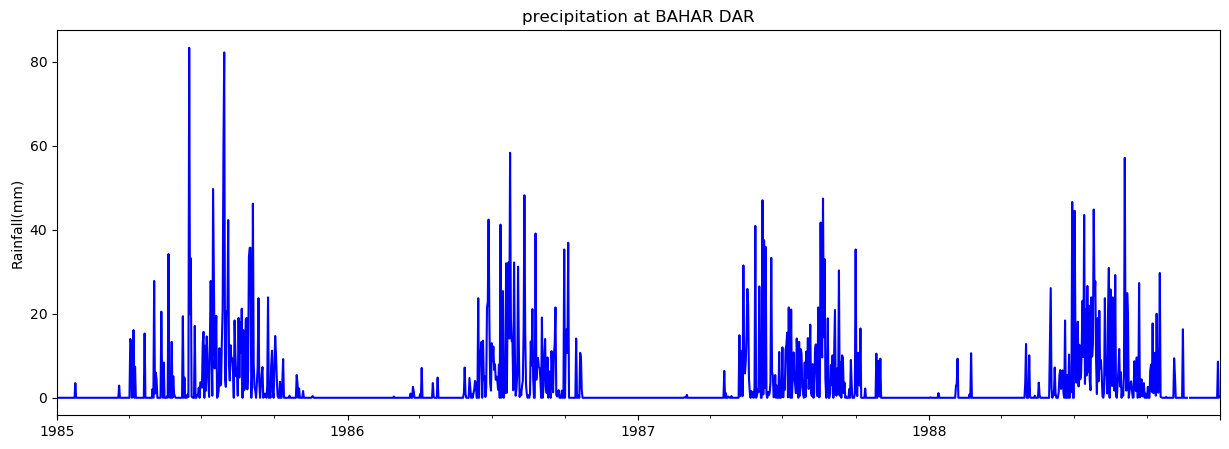

In [26]:
# Insert information only for choosing a sub-period of the whole series
time_start = None    # Set a date in the format 'YYYY-MM-DD' or None for plot the series from the beginning
time_end = None      # Set a date in the format 'YYYY-MM-DD' or None for plot the series up to the end
####################################################################

# Read data series
variable = var_chooser.value
temp_series = full_series[[dic_vars[variable][0]]]/10

# Set time range
time_start = temp_series.first_valid_index() if time_start is None else pd.to_datetime(time_start,format='%Y-%m-%d')
time_end = temp_series.last_valid_index() if time_end is None else pd.to_datetime(time_end,format='%Y-%m-%d')
if time_start > time_end:
    raise ValueError("time_start is larger than time_end, verify your data!")
time_range = pd.date_range(time_start,time_end,freq='1D')
temp_series = temp_series.reindex(time_range)

display(temp_series)

# Manage plot
ax = temp_series.plot(style='b', title=variable + ' at ' + section_name, figsize=(15,5))
ax.set_xlabel("")
ax.set_ylabel(dic_vars[variable][1])
ax.get_legend().remove()
plt.show()

In [ ]:
Time series can be asily managed with python for resampling and statistical operations:

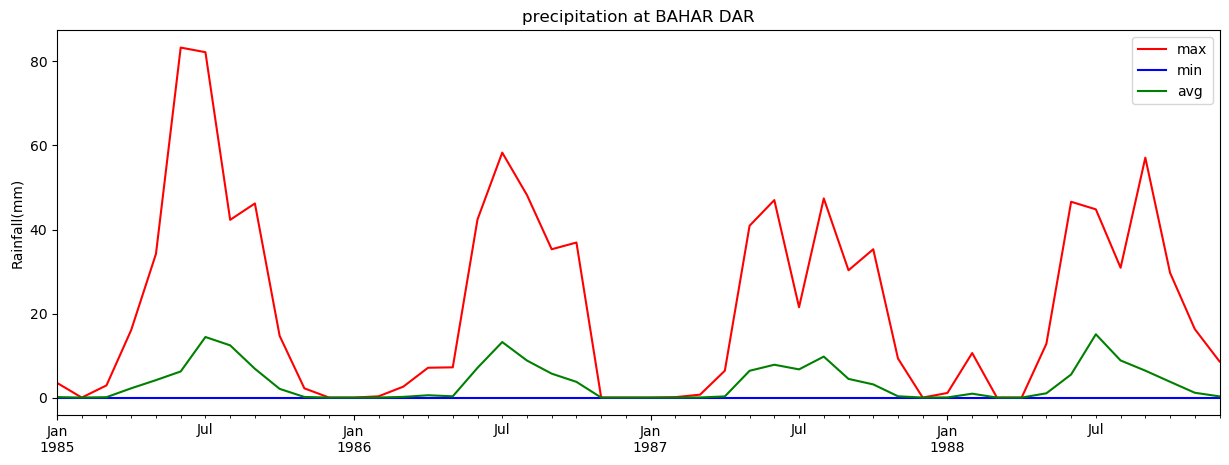

In [27]:
# The resample frequency can be set, e.g., to annual 'Y' or monthly 'M'
temp_resampled_max = temp_series.reindex(time_range).resample('M').max()
temp_resampled_min = temp_series.reindex(time_range).resample('M').min()
temp_resampled_avg = temp_series.reindex(time_range).resample('M').mean()

# Manage plot
ax = temp_resampled_max.plot(style='r', title=variable + ' at ' + section_name, figsize=(15,5))
temp_resampled_min.plot(style='b',ax=ax)
temp_resampled_avg.plot(style='g',ax=ax)
ax.set_xlabel("")
ax.set_ylabel(dic_vars[variable][1])
plt.legend(['max','min','avg'])
plt.show()

---

## 🌊 Flood frequency analysis

#### Carve DEM

We can use python to compute flood statistics on a discharge timeseries. Reference to *hydro-informatics.github.io* <br>

Occurence of relevant (extreme) flood events can be expressed as **return period**, expressing the average recurrence interval of an event of a certain magnitude in units of time. It is the inverse of the **exceedance probability** (the likelihood of an event of a certain magnitude or higher).<br>
A significant assumption in calculating the return period is that individual events are assumed indipendent. This means that, for any given year, the probability of a 100-year flood occurring is 1/100.
Here below a table showing the recurrence intervals and related probabilities of occurrences.

| Return Period (years) | Annual exceeding probability (%) |
| --- | --- |
| 2 | 50 |
| 5 | 10 |
| 10 | 10 |
| 50 | 2 |
| 100 | 1 |
| 500 | 0.2 |

At first we should import some useful libraries:

In [37]:
import numpy as np
import pandas as pd
import glob
import os
import zipfile

Then, we should import the discharge data. Let's see what "txt" series files can be find inside the "../sources/datasets/grdc" folder. Further data can be downloaded from the GRDC data portal by performing a custom request (https://portal.grdc.bafg.de/applications/public.html?publicuser=PublicUser#dataDownload/Stations). The request will be evaluated by the data provider and in not much time an email with a download url will be provided. The url can be inserted and diectly analysed with this tool:

In [38]:
files = glob.glob("../sources/datasets/grdc/*.txt")
print(*files, sep="\n")

../sources/datasets/grdc/1566207_Q_Day.Cmd.txt
../sources/datasets/grdc/1563700_Q_Day.Cmd.txt
../sources/datasets/grdc/1563750_Q_Day.Cmd.txt
../sources/datasets/grdc/1563800_Q_Day.Cmd.txt
../sources/datasets/grdc/1566270_Q_Day.Cmd.txt
../sources/datasets/grdc/1577300_Q_Day.Cmd.txt
../sources/datasets/grdc/1578200_Q_Day.Cmd.txt
../sources/datasets/grdc/1582700_Q_Day.Cmd.txt
../sources/datasets/grdc/1577602_Q_Day.Cmd.txt
../sources/datasets/grdc/1582850_Q_Day.Cmd.txt
../sources/datasets/grdc/1563450_Q_Day.Cmd.txt
../sources/datasets/grdc/1582800_Q_Day.Cmd.txt
../sources/datasets/grdc/1564500_Q_Day.Cmd.txt
../sources/datasets/grdc/1577800_Q_Day.Cmd.txt
../sources/datasets/grdc/1577601_Q_Day.Cmd.txt
../sources/datasets/grdc/1563900_Q_Day.Cmd.txt
../sources/datasets/grdc/1577050_Q_Day.Cmd.txt
../sources/datasets/grdc/1577101_Q_Day.Cmd.txt
../sources/datasets/grdc/1577500_Q_Day.Cmd.txt
../sources/datasets/grdc/1580300_Q_Day.Cmd.txt
../sources/datasets/grdc/1582820_Q_Day.Cmd.txt
../sources/da

The list don't tell us much abouyt the file content, we can open one of them to understand the content of each file

NOTE! Python numbering starts from 0!!:

In [39]:
# Read a preview of the file
number_of_lines = 40

with open(files[0],'rb') as file:
    for i in np.arange(0,number_of_lines,1): 
        line = file.readline().decode('ISO-8859-1')
        print(str(i) + ' ' + line)

0 # Title:                 GRDC STATION DATA FILE

1 #                        --------------

2 # Format:                DOS-ASCII

3 # Field delimiter:       ;

4 # missing values are indicated by -999.000

5 #

6 # file generation date:  2025-08-07

7 #

8 # GRDC-No.:              1566207

9 # River:                 RIVER BARO

10 # Station:               U/SBARO-ADURA BIFURCATION

11 # Country:               ET

12 # Latitude (DD):       8.3333

13 # Longitude (DD):      33.9333

14 # Catchment area (km²):      -999.0

15 # Altitude (m ASL):        -999.00

16 # Next downstream station:      1566206

17 # Remarks:               

18 # Owner of original data: United Kingdom - Centre for Ecology and Hydrology (CEH) Wallingford

19 #************************************************************

20 #

21 # Data Set Content:      MEAN DAILY DISCHARGE (Q)

22 #                        --------------------

23 # Unit of measure:                  m³/s

24 # Time series:            - 

25 # No

The lines between 8 and 18 of each file contains all the information about the station, we can use python capability of manage different file type to summarize those information in a table:

In [36]:
# Read the 11 lines after line 8 (Python numbering starts from 0!)
for ind, file in enumerate(files,0):
    data = pd.read_csv(file, skiprows=8, nrows=11, sep=":", encoding='ISO-8859-1', header=None, names=['cod','val'])    
    if ind == 0:
        list_vars = [i.replace('# ','') for i in data['cod']]
        df_stations = pd.DataFrame(index=np.arange(0,len(files),1),columns=list_vars)
    data['cod'] = list_vars
    data = data.set_index(['cod'])
    for var in list_vars:
        df_stations.loc[ind][var] = data.loc[var].values[0].strip()

df_stations = df_stations.set_index(["GRDC-No."])
display(df_stations)

,River,Station,Country,Latitude (DD),Longitude (DD),Catchment area (km²),Altitude (m ASL),Next downstream station,Remarks,Owner of original data
GRDC-No.,,,,,,,,,,
1566207,RIVER BARO,U/SBARO-ADURA BIFURCATION,ET,8.3333,33.9333,-999.0,-999.00,1566206,,United Kingdom - Centre for Ecology and Hydrol...
1563700,GUDER WENZ,GUDER,ET,8.95,37.75,524.0,2050.0,1563100,,Initial dataset collected in the framework of ...
1563750,BLUE NILE,NEAR THE LAKE TANA,ET,11.57708,37.41042,-999.0,-999.00,1563100,,Initial dataset collected in the framework of ...
1563800,BLUE NILE,KESSIE,ET,10.06875,38.18125,65784.0,-999.00,1563750,,Initial dataset collected in the framework of ...
1566270,MAKWAI,JUNCTION WITH ADURA,ET,8.1167,33.6167,-999.0,-999.00,1566261,,United Kingdom - Centre for Ecology and Hydrol...
1577300,K'ELET'A WENZ,SIRE VILLAGE,ET,8.27,39.4,745.0,1560.0,1577102,,Initial dataset collected in the framework of ...
1578200,MERIBO SHET',NEAR ADABA BRIDGE,ET,7.0,39.33,200.0,2350.0,-,,Initial dataset collected in the framework of ...
1582700,GIBE WENZ,NEAR ABELTI,ET,8.23,37.58,15746.0,-999.00,-,,Initial dataset collected in the framework of ...
1577602,AWASH WENZ,ADAITU,ET,11.133333,40.783333,52835.0,-999.00,1577603,,"Ethiopia - Ministry of Water Resources, Hydrol..."


We can now choose which station to analyse by providing its code to identify the related file, let's start, for example, with the AWASH WENZ at MELKA KUNTIRE (COD: 1577100):

Text(0, 0.5, 'Q (m3/s)')

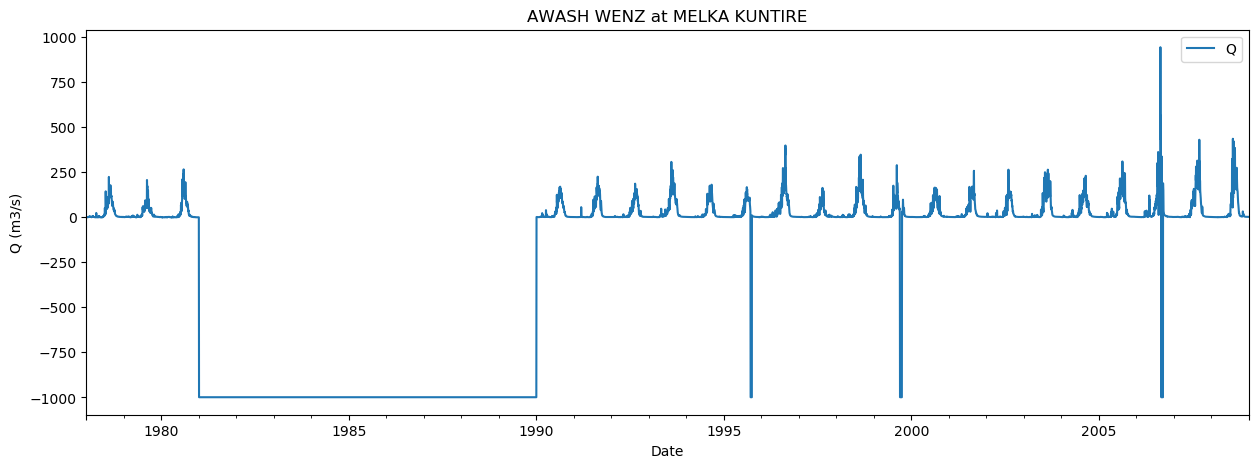

In [42]:
# Please, specify an available station code
station_code = '1577100'
##############################################################################################

# Read data from line 37
df = pd.read_csv("../sources/datasets/grdc/" + station_code + "_Q_Day.Cmd.txt",
                 header=None,
                 sep=";",
                 skiprows=37,
                 names=["Date", "Time","Q"],
                 parse_dates=[0],
                 index_col=["Date"],
    encoding="latin-1")
df['Q']=df['Q'].astype(float)
ax = df.plot(title=df_stations.loc[station_code]["River"] + " at " + df_stations.loc[station_code]["Station"], figsize=(15,5))
ax.set_ylabel('Q (m3/s)')

There are negative values in the series, that corresponds to null values, we can mange them by repalacing with "np.nan" that is the standard numpy null value:



Text(0, 0.5, 'Q (m3/s)')

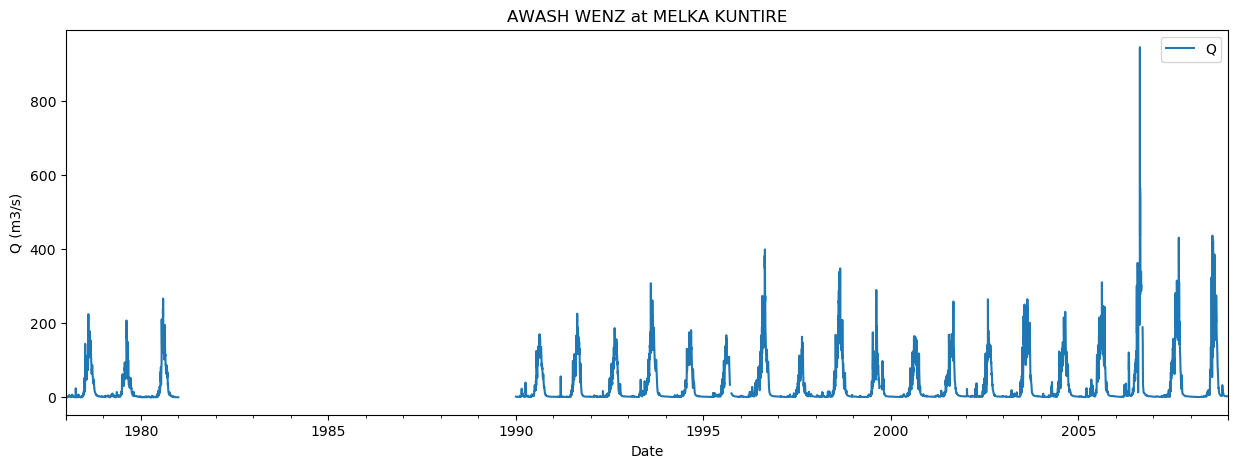

In [43]:
# Replace negative values with "null"
df.loc[df['Q']<0,'Q']=np.nan
ax = df.plot(title=df_stations.loc[station_code]["River"] + " at " + df_stations.loc[station_code]["Station"], figsize=(15,5))
ax.set_ylabel('Q (m3/s)')

This is the complete timeseries: we have to select only the yearly maxima. It is quite straightforward with pandas dataframe, we can resample our dataset (which has been indexed with dates).

     Time        Q  year
0   --:--  224.000  1978
1   --:--  207.000  1979
2   --:--  266.000  1980
12  --:--  169.851  1990
13  --:--  225.398  1991
14  --:--  186.504  1992
15  --:--  307.421  1993
16  --:--  180.862  1994
17  --:--  167.155  1995
18  --:--  398.626  1996
19  --:--  163.154  1997
20  --:--  347.518  1998
21  --:--  289.232  1999
22  --:--  164.060  2000
23  --:--  258.119  2001
24  --:--  264.301  2002
25  --:--  264.301  2003
26  --:--  230.376  2004
27  --:--  309.959  2005
28  --:--  944.125  2006
29  --:--  430.396  2007
30  --:--  435.912  2008


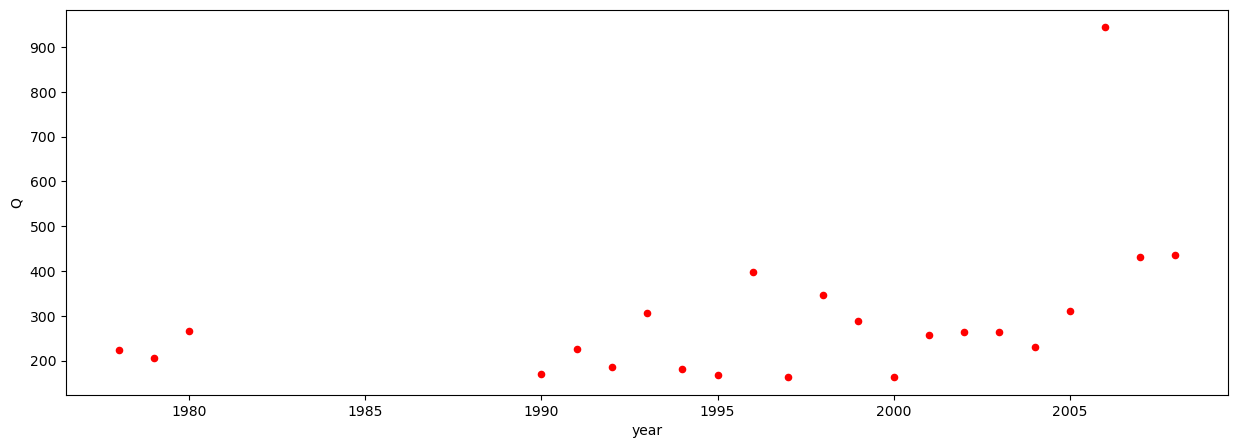

In [44]:
# Resample using the annual maximum value
df_ymax = df.resample("Y").max()
df_ymax["year"] = df_ymax.index.year
df_ymax.reset_index(inplace=True, drop=True)
df_ymax = df_ymax.dropna()
print(df_ymax)

# Manage plot
df_ymax.plot(kind='scatter',x='year',y='Q',color='red', figsize=(15,5))
plt.show()

#### Return period analysis

We should compute the exceedence probability Pr, and the resulting recurrence interval. Pr is defined as: 
 
$Pr_{i} = {(n-i+1)}/{(n+1)}$. Where n is the total number of observation years and i is the rank of the event.

In [45]:
# Sort in increasing order
df_ymax_sorted = df_ymax.sort_values(by="Q")
n = df_ymax_sorted.shape[0]
df_ymax_sorted.insert(0, "rank", range(1, 1 + n))
print(df_ymax_sorted)

    rank   Time        Q  year
19     1  --:--  163.154  1997
22     2  --:--  164.060  2000
17     3  --:--  167.155  1995
12     4  --:--  169.851  1990
16     5  --:--  180.862  1994
14     6  --:--  186.504  1992
1      7  --:--  207.000  1979
0      8  --:--  224.000  1978
13     9  --:--  225.398  1991
26    10  --:--  230.376  2004
23    11  --:--  258.119  2001
24    12  --:--  264.301  2002
25    13  --:--  264.301  2003
2     14  --:--  266.000  1980
21    15  --:--  289.232  1999
15    16  --:--  307.421  1993
27    17  --:--  309.959  2005
20    18  --:--  347.518  1998
18    19  --:--  398.626  1996
29    20  --:--  430.396  2007
30    21  --:--  435.912  2008
28    22  --:--  944.125  2006


The exceedence probability ( pr ) can be calculated applying the formula:

In [47]:
df_ymax_sorted["pr"] = (n - df_ymax_sorted["rank"] + 1) / (n + 1)
print(df_ymax_sorted)

    rank   Time        Q  year        pr
19     1  --:--  163.154  1997  0.956522
22     2  --:--  164.060  2000  0.913043
17     3  --:--  167.155  1995  0.869565
12     4  --:--  169.851  1990  0.826087
16     5  --:--  180.862  1994  0.782609
14     6  --:--  186.504  1992  0.739130
1      7  --:--  207.000  1979  0.695652
0      8  --:--  224.000  1978  0.652174
13     9  --:--  225.398  1991  0.608696
26    10  --:--  230.376  2004  0.565217
23    11  --:--  258.119  2001  0.521739
24    12  --:--  264.301  2002  0.478261
25    13  --:--  264.301  2003  0.434783
2     14  --:--  266.000  1980  0.391304
21    15  --:--  289.232  1999  0.347826
15    16  --:--  307.421  1993  0.304348
27    17  --:--  309.959  2005  0.260870
20    18  --:--  347.518  1998  0.217391
18    19  --:--  398.626  1996  0.173913
29    20  --:--  430.396  2007  0.130435
30    21  --:--  435.912  2008  0.086957
28    22  --:--  944.125  2006  0.043478


The recurrence interval( return-period ) is the inverse of the probability, thus:

In [48]:
df_ymax_sorted["return-period"] = 1 / df_ymax_sorted["pr"]
print(df_ymax_sorted)

    rank   Time        Q  year        pr  return-period
19     1  --:--  163.154  1997  0.956522       1.045455
22     2  --:--  164.060  2000  0.913043       1.095238
17     3  --:--  167.155  1995  0.869565       1.150000
12     4  --:--  169.851  1990  0.826087       1.210526
16     5  --:--  180.862  1994  0.782609       1.277778
14     6  --:--  186.504  1992  0.739130       1.352941
1      7  --:--  207.000  1979  0.695652       1.437500
0      8  --:--  224.000  1978  0.652174       1.533333
13     9  --:--  225.398  1991  0.608696       1.642857
26    10  --:--  230.376  2004  0.565217       1.769231
23    11  --:--  258.119  2001  0.521739       1.916667
24    12  --:--  264.301  2002  0.478261       2.090909
25    13  --:--  264.301  2003  0.434783       2.300000
2     14  --:--  266.000  1980  0.391304       2.555556
21    15  --:--  289.232  1999  0.347826       2.875000
15    16  --:--  307.421  1993  0.304348       3.285714
27    17  --:--  309.959  2005  0.260870       3

Once create the table (dataframe) with all required information (Probability and Return-Period) we might plot it to visualise the recurrence interval of each observed discharge. It is worth mentioning that this analysis and the resulting plot refer only to observed values.

To extrapolate recurrence interval beyond the observation period (the 1-in-100 years flood values, for instance) a prediction model is needed (Gumbel, GEV, etc..).

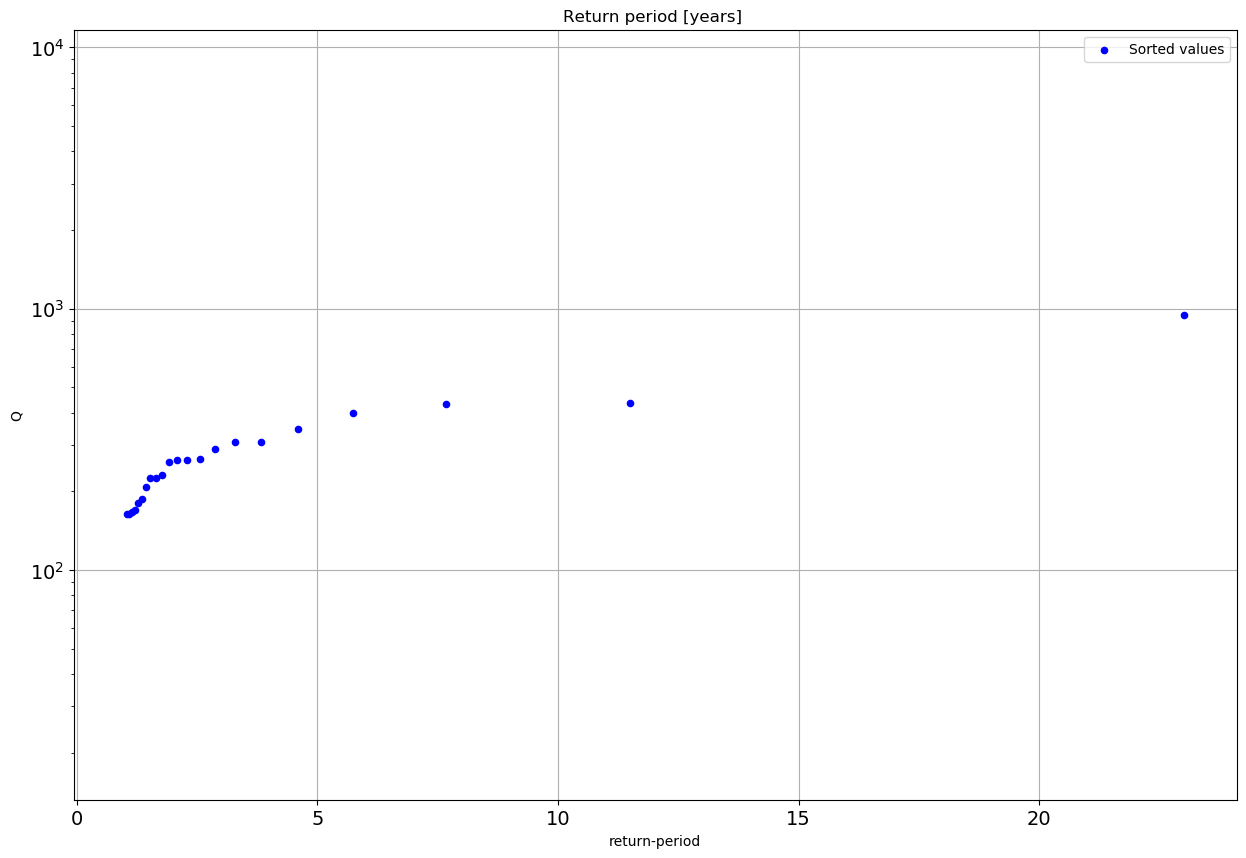

In [50]:
df_ymax_sorted.plot.scatter(y="Q",
                         x="return-period",
                         title="Return period [years] ",
                         color='blue',
                         grid=True,
                         fontsize=14,
                         logy=false,
                         label="Sorted values",
                         figsize=(15,10))

## 🎉 That is for this brief practical introduction to Python!